In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.0.0+cpu
None


In [ ]:
pip install torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cpu.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ---------------------------------------- 1.3/1.3 MB 8.1 MB/s  0:00:00

   -------------------- ------------------- 1/2 [torch-geometric]
   -------------------- ------------------- 1/2 [torch-geometric]
   -------------------- ------------------- 1/2 [torch-geometric]
   -------------------- ------------------- 1/2 [torch-geometric]
   -------------------- ------------------- 1/2 [torch-geometric]
   -------------------- ------------------- 1/2 [torch-geometric]
   -------------------- ------------------- 1/2 [torch-geometric]
   -------------------- ------------------- 1/2 [torch-geometric]
   -------------------- ------------------- 1/2 [torch-geometric]
   -------------------- ------------------- 1/2 [torch-geometric]
   -------------------- ------------------- 1/2 [torch-geometric]
   -------------------- ------------------- 1/2 [torch-geometric]
 


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import torch_geometric
from torch_geometric.nn import GCNConv
print("PyTorch Geometric version:", torch_geometric.__version__)


PyTorch Geometric version: 2.7.0


Epoch 0: loss = 0.8701
Epoch 50: loss = 0.4949
Epoch 100: loss = 0.4835
Epoch 150: loss = 0.4771
Epoch 200: loss = 0.4766
Epoch 250: loss = 0.4762


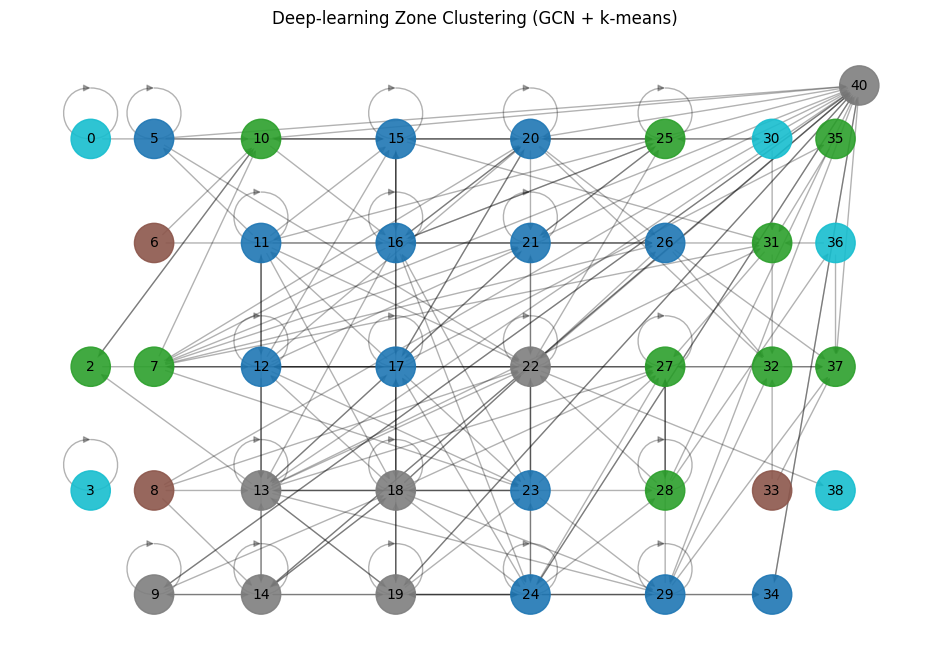

In [ ]:
# ============================================================
# Deep-learning clustering of football zone transition graph
# ============================================================

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Convert NetworkX graph -> PyG format
# -----------------------------

def prepare_pyg_data(G):
    """
    Converts a zone transition graph (NetworkX) into a PyTorch Geometric Data object.
    Node features can include event frequencies, degree, or custom attributes.
    """
    # Basic node feature: [in_degree, out_degree, total_weight]
    features = []
    for n in G.nodes():
        in_deg = G.in_degree(n, weight='weight')
        out_deg = G.out_degree(n, weight='weight')
        total_w = in_deg + out_deg
        features.append([in_deg, out_deg, total_w])
    X = torch.tensor(np.array(features, dtype=np.float32))
    data = from_networkx(G)
    data.x = X
    return data

# -----------------------------
# 2️⃣ Define Graph Autoencoder (GCN Encoder)
# -----------------------------

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# -----------------------------
# 3️⃣ Train Autoencoder to reconstruct adjacency
# -----------------------------

def train_graph_autoencoder(G, hidden_dim=8, latent_dim=2, epochs=300, lr=0.01):
    data = prepare_pyg_data(G)
    model = GCNEncoder(data.x.shape[1], hidden_dim, latent_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    A_true = torch.tensor(nx.to_numpy_array(G, weight='weight'), dtype=torch.float)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        Z = model(data.x, data.edge_index)
        A_pred = torch.sigmoid(torch.mm(Z, Z.t()))
        loss = F.mse_loss(A_pred, A_true)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}: loss = {loss.item():.4f}")

    with torch.no_grad():
        embeddings = model(data.x, data.edge_index).numpy()

    return embeddings

# -----------------------------
# 4️⃣ Cluster embeddings (e.g., K-means)
# -----------------------------

def cluster_embeddings(embeddings, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    return labels

# -----------------------------
# 5️⃣ Visualization on the pitch zones
# -----------------------------

def visualize_clusters(G, embeddings, labels, zt=None, figsize=(12,8), title="Deep Zone Clustering"):
    plt.figure(figsize=figsize)
    if zt is not None and hasattr(zt, "get_zone_center"):
        pos = {n: zt.get_zone_center(n) for n in G.nodes()}
    else:
        pos = nx.spring_layout(G, seed=42)

    colors = plt.cm.tab10(labels / max(labels))
    nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=800, alpha=0.9)
    nx.draw_networkx_edges(G, pos, alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(title)
    plt.axis("off")
    plt.show()

# -----------------------------
# 6️⃣ Run full pipeline
# -----------------------------

# Example usage:
# Assuming you already have G_home and zt from your previous code

embeddings = train_graph_autoencoder(G_home, hidden_dim=8, latent_dim=2, epochs=300)
labels = cluster_embeddings(embeddings, n_clusters=5)
visualize_clusters(G_home, embeddings, labels, zt, title="Deep-learning Zone Clustering (home team)")


In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(embeddings, labels)
print(f"Silhouette score: {score:.3f}")


Silhouette score: 0.403


Epoch 0: loss = 1.6107
Epoch 50: loss = 1.2238
Epoch 100: loss = 1.2054
Epoch 150: loss = 1.1971
Epoch 200: loss = 1.1878
Epoch 250: loss = 1.1824


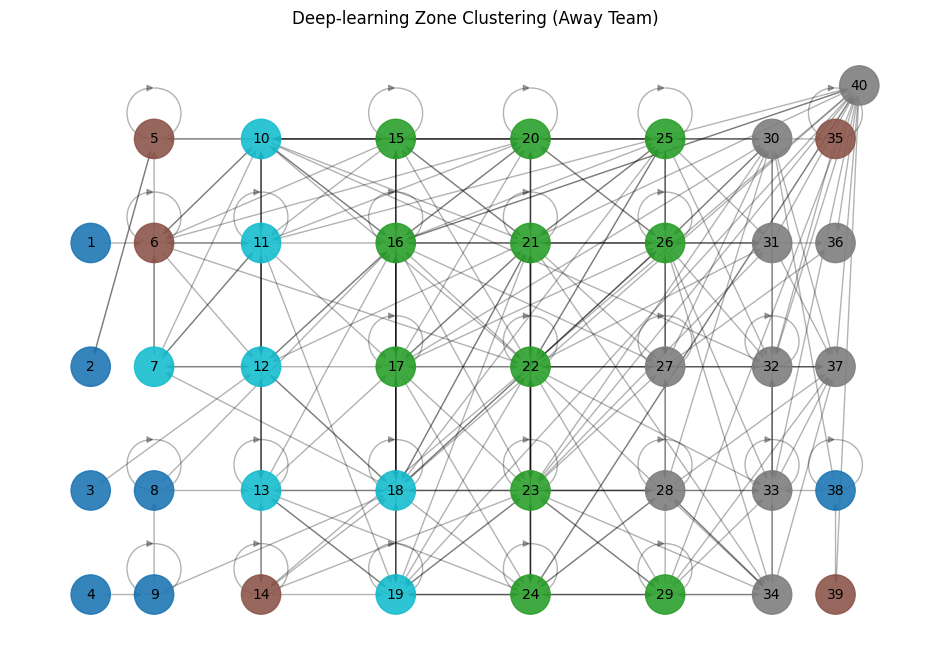

In [ ]:
# ================================
# Run on AWAY team transition graph
# ================================

embeddings_away = train_graph_autoencoder(G_away, hidden_dim=8, latent_dim=2, epochs=300)
labels_away = cluster_embeddings(embeddings_away, n_clusters=5)
visualize_clusters(G_away, embeddings_away, labels_away, zt, title="Deep-learning Zone Clustering (Away Team)")


In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(embeddings_away, labels_away)
print(f"Silhouette score: {score:.3f}")

Silhouette score: 0.439
